In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pipeline import mini_algo, threshold_on_score, keep_valid_molecules, check_pains_brenk
from utils import evaluate_model

/Users/jackie16201/Desktop/Spring_2023/fragments_discovery_design_ML/src/pipeline.py:11: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  from rdkit.Chem import MCS
<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.


# Part 1: Get neural network baseline

First, we trained an underpowered model on the 2.3K compound staph screen. We use this model to predict on the 37K staph screen and the 27mil fragments. Training code can be found in 05_in_silico_algorithm_control.sh.

359 experimental hits out of 1518.0 predicted hits
precision recall: 0.08686796118642708


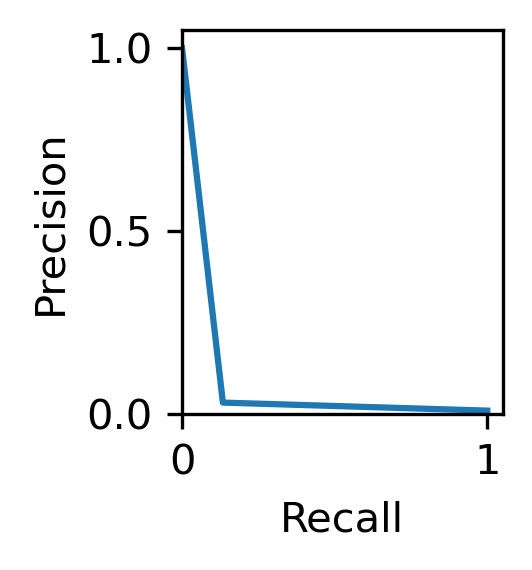

recall: 
0.13370473537604458
precision: 
0.03162055335968379


In [7]:
cpd_df = pd.read_csv('../out/controls/in_silico_algorithm_control_SA_37k_predictions_with_2300_model.csv')
all_cpd_df = cpd_df.copy()

# use the algo-predicted cpds as "positive" and the rest of cpds as negative - FOR ALL CPDS
all_cpd_df['predicted_with_gnn'] = [1.0 if x > 0.2 else 0.0 for x in list(all_cpd_df['class'])]
all_cpd_df['experimental_hit'] = list(all_cpd_df['Mean_50uM'] < 0.2)
print(str(sum(all_cpd_df['experimental_hit'])) + ' experimental hits out of ' + str(sum(all_cpd_df['predicted_with_gnn'])) + ' predicted hits')
evaluate_model(all_cpd_df, cutoff_for_positive = 0.2, actual_col='experimental_hit', predicted_col='predicted_with_gnn')

# Part 2: Get neural network baseline plus checking for PAINS and Brenk like fragment algorithm

length of cpd preds:  36977
length of df >0.2:  1518
length of df with valid mols:  1518
length of all preds with clean (no PAINS or Brenk) mols:  1351
359 experimental hits out of 1351.0 predicted hits
precision recall: 0.039841008255136576


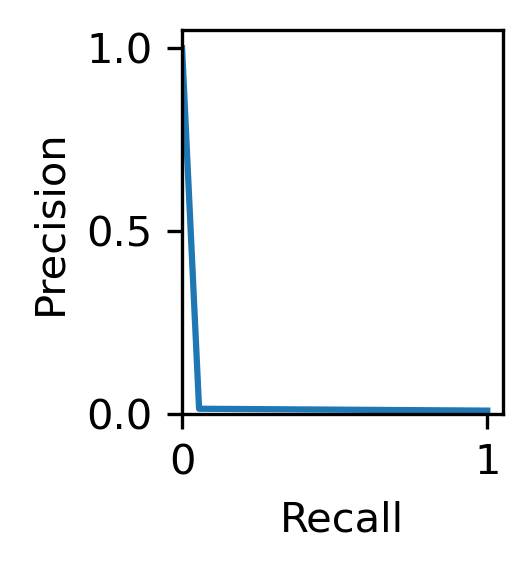

recall: 
0.055710306406685235
precision: 
0.014803849000740192


In [8]:
print('length of cpd preds: ', len(cpd_df))
# threshold on score
cpd_df = threshold_on_score(cpd_df, 0.2, 'class')
# keep only valid molecules
cpd_df, cpd_mols = keep_valid_molecules(cpd_df, 'SMILES')
# keep only molecules without pains or brenk
cpd_df, cpd_mols = check_pains_brenk(cpd_df, cpd_mols)

predicted_positive_cpds = list(cpd_df['Compound_ID'])
all_cpd_df['predicted_with_gnn_plus_processing'] = [1.0 if x in predicted_positive_cpds else 0.0 for x in list(all_cpd_df['Compound_ID'])]
print(str(sum(all_cpd_df['experimental_hit'])) + ' experimental hits out of ' + str(sum(all_cpd_df['predicted_with_gnn_plus_processing'])) + ' predicted hits')
evaluate_model(all_cpd_df, cutoff_for_positive = 0.2, actual_col='experimental_hit', predicted_col='predicted_with_gnn_plus_processing')


# Part 3: Actual fragment algorithm test

In [10]:
# Values for processing fragments and compounds
fragment_path = '../out/controls/in_silico_algorithm_control_SA_all_combined_fragment_preds_gdb11_with_2300.csv'
compound_path = '../out/controls/in_silico_algorithm_control_SA_37k_predictions_with_2300_model.csv'
result_path = '../out/controls/in_silico_algorithm_control_SA_'
fragment_smi_col = 'SMILES'
compound_smi_col = 'SMILES'
fragment_hit_col = 'class'
compound_hit_col = 'class'

# filters and thresholds for fragments and compounds
fragment_score = 0.1
compound_score = 0.2
fragment_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
compound_remove_pains_brenk = 'both' # one of 'both', 'pains', 'brenk', 'none'
fragment_require_more_than_coh = True

rank_df = mini_algo(fragment_path=fragment_path,
                    compound_path=compound_path,
                    result_path=result_path,
                    fragment_smi_col=fragment_smi_col,
                    compound_smi_col=compound_smi_col,
                    fragment_hit_col=fragment_hit_col,
                    compound_hit_col=compound_hit_col,
                    fragment_score=fragment_score,
                    compound_score=compound_score,
                    fragment_remove_pains_brenk=fragment_remove_pains_brenk,
                    compound_remove_pains_brenk=compound_remove_pains_brenk, 
                    fragment_require_more_than_coh=fragment_require_more_than_coh)

# save rank_df
rank_df = rank_df.sort_values('number_of_matched_molecules', ascending = False)

# take only the largest frags
rank_df = rank_df[rank_df['length_of_fragment'] > 7]
rank_df = rank_df[rank_df['number_of_matched_molecules'] < 400]

# get the final matching molecules for saving
all_matching_mol_indices = [x for l in list(rank_df['matched_molecules']) for x in l]

# deduplicate
all_matching_mol_indices = list(set(all_matching_mol_indices))
print('final number of molecules to test: ', len(all_matching_mol_indices))

# save the names
cpd_smiles = list(cpd_df['SMILES'])
all_matching_smis = [cpd_smiles[i] for i in list(set(all_matching_mol_indices))]

# and save the final molecules to df
all_matching_mols_df = pd.DataFrame()
all_matching_mols_df['SMILES'] = all_matching_smis
all_matching_mols_df

final_merge_df = all_matching_mols_df.merge(all_cpd_df, on = 'SMILES')
final_merge_df = final_merge_df.sort_values('class', ascending = False)
final_merge_df.to_csv('../out/controls/in_silico_algorithm_control_SA_final_proposed_fake_mols_to_order.csv', index = False)

predicted_positive_cpds = list(final_merge_df['Compound_ID'])
all_cpd_df['predicted_with_algo'] = [1.0 if x in predicted_positive_cpds else 0.0 for x in list(all_cpd_df['Compound_ID'])]
print(str(sum(all_cpd_df['experimental_hit'])) + ' experimental hits out of ' + str(sum(all_cpd_df['predicted_with_algo'])) + ' predicted hits')
evaluate_model(all_cpd_df, cutoff_for_positive = 0.2, actual_col='experimental_hit', predicted_col='predicted_with_algo')



Processing fragments...
length of df:  25020000
length of df >0.1:  3307974
length of df with valid mols:  3307974
length of all preds with clean (no PAINS or Brenk) mols:  1241826

Processing compounds...
length of df:  36977
length of df >0.2:  1518
length of df with valid mols:  1518
length of all preds with clean (no PAINS or Brenk) mols:  1351

Matching fragments in compounds...


KeyboardInterrupt: 

In [18]:
# from notebook 15.2_in_silico_control_of_fragments_pipeline_with_2300_model_applied_to_37K_screen_space_GDB11_09282022
df = pd.read_csv('../data/in_silico_algorithm_control/frag_chunks_gdb11_with_sa_model_preds/all_combined_fragment_preds_in_silico_gdb11_09_29_2022.csv')

#df = pd.read_csv('../out/predictions_with_revised_sa_model/FINISHED_combined_fragment_preds_05_24_2022.csv')
print('length of all preds: ', len(df))

# threshold on score
df = threshold_on_score(df, 0.1, 'class')

# keep only frags with more than just C, O, H
df = require_more_than_coh(df, 'SMILES')

# keep only valid frags
df, mols = keep_valid_molecules(df, 'SMILES')

# keep only frags without pains or brenk
df, mols = check_pains_brenk(df, mols)

# get all matching frag / molecule pairs
frag_match_indices, cpd_match_indices_lists = match_frags_and_mols(mols, cpd_mols)

# for all matching fragments, keep only matches that do not disrupt rings
frag_match_indices, cpd_match_indices_lists = check_for_complete_ring_fragments(mols, frag_match_indices, cpd_mols, cpd_match_indices_lists)

# make df
rank_df = pd.DataFrame()
rank_df['matched_fragments'] = frag_match_indices
rank_df['fragment_SMILES'] = [mols[i].GetProp('SMILES') for i in list(rank_df['matched_fragments'])]
rank_df['length_of_fragment'] = [mols[i].GetNumAtoms() for i in frag_match_indices]
rank_df['matched_molecules'] = cpd_match_indices_lists
rank_df['number_of_matched_molecules'] = [len(m) for m in cpd_match_indices_lists]
rank_df['fragment_scores'] = [df.iloc[i,list(df.columns).index('class')] for i in frag_match_indices]
rank_df['full_molecule_scores'] = [[cpd_df.iloc[i,list(cpd_df.columns).index('class')] for i in sublist] for sublist in cpd_match_indices_lists]
rank_df['average_molecule_score'] = [np.mean([float(x) for x in sublist]) for sublist in list(rank_df['full_molecule_scores'])]

# save rank_df
rank_df = rank_df.sort_values('number_of_matched_molecules', ascending = False)

# take only the largest frags
rank_df = rank_df[rank_df['length_of_fragment'] > 7]
rank_df = rank_df[rank_df['number_of_matched_molecules'] < 400]

# get the final matching molecules for saving
all_matching_mol_indices = [x for l in list(rank_df['matched_molecules']) for x in l]

# deduplicate
all_matching_mol_indices = list(set(all_matching_mol_indices))
print('final number of molecules to test: ', len(all_matching_mol_indices))

# save the names
cpd_smiles = list(cpd_df['SMILES'])
all_matching_smis = [cpd_smiles[i] for i in list(set(all_matching_mol_indices))]

# and save the final molecules to df
all_matching_mols_df = pd.DataFrame()
all_matching_mols_df['SMILES'] = all_matching_smis
all_matching_mols_df

final_merge_df = all_matching_mols_df.merge(cpd_df, on = 'SMILES')
final_merge_df = final_merge_df.sort_values('class', ascending = False)
final_merge_df.to_csv('../out/controls/in_silico_algorithm_control_notebooks_15/final_proposed_fake_mols_to_order_SA_05152023.csv', index = False)
final_merge_df

length of all preds:  25020000
length of df >0.1:  3307974
length of df with more than C,O,H characters:  3202807


100%|██████████████████████████████| 3202807/3202807 [02:45<00:00, 19399.74it/s]


length of df with valid mols:  3202807


100%|███████████████████████████████| 3202807/3202807 [48:28<00:00, 1101.17it/s]


length of all preds with clean (no PAINS or Brenk) mols:  1188761


1188761it [2:52:56, 114.56it/s]


number of matched fragments:  229
final number of molecules to test:  42


,SMILES,Broad_plate,Well_number,Compound_ID,Plate_num,R1_50uM,R2_50uM,Mean_50uM,class
35,OC[C@H]1CN(C(=O)O1)c1ccc(c(c1)F)OCC1(O)CCN(CC1...,BR00120106,F18,BRD-K00003370,25,0.404351,0.369473,0.386912,0.456710
2,N[C@H]1CCN(C1)c1nc2c(cc1F)C(=O)C(=CN2c1ccc(cc1...,BR00120108,C19,BRD-K01825158,27,0.148113,0.163705,0.155909,0.368513
40,COc1cc(ccc1NC(=O)[C@@H]1N[C@@H](CC(C)(C)C)[C@@...,BR00123006,F20,BRD-K62627508,69,0.396960,0.266124,0.331542,0.343931
4,C[C@@H]1CN(CC(=O)N2CC(C)(C)c3nc(c(cc32)Cc2ccc(...,BR00120108,J14,BRD-K00003508,27,0.978752,0.960347,0.969549,0.323116
33,CC(C)(O)c1cn(c(n1)C(C)(C)c1c(cccc1Cl)Cl)-c1ccc...,BR00120106,C01,BRD-K00003439,25,1.240913,1.100269,1.170591,0.313394
12,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,BR00123019,F05,BRD-K49668410,73,0.187864,0.098723,0.143293,0.286288
37,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,BR00120106,G16,BRD-K74501079,25,0.216969,0.215361,0.216165,0.278660
11,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,BR00123019,F04,BRD-A12097279,73,0.108865,0.103101,0.105983,0.266455
3,CC(C)N1C[C@@H](CN(C)CCc2ccc(c(c2)Cl)Cl)Oc2c(cc...,BR00122905,N03,BRD-K34903139,92,1.094700,1.108547,1.101624,0.255069
27,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,BR00123015,E08,BRD-K39746403,79,0.335056,0.352691,0.343873,0.252829


In [48]:
# use the algo-predicted cpds as "positive" and the rest of cpds as negative
all_cpd_df = pd.read_csv('../out/controls/in_silico_algorithm_control_notebooks_15/37k_predictions_with_2300_model.csv')

predicted_positive_cpds = list(final_merge_df['Compound_ID'])
all_cpd_df['predicted_with_algo'] = [1.0 if x in predicted_positive_cpds else 0.0 for x in list(all_cpd_df['Compound_ID'])]
print(sum(all_cpd_df['predicted_with_algo']))
print(len(all_cpd_df))

actual = list(all_cpd_df['Mean_50uM'] < thresh) # lower is better
predicted = list(all_cpd_df['predicted_with_algo'])

print('recall: ')
print(metrics.recall_score(actual, predicted))
print('precision: ')
print(metrics.precision_score(actual, predicted))

42.0
36977
recall: 
0.022284122562674095
precision: 
0.19047619047619047
